In [6]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import unicodedata
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam

# 1. Problem & Data Description

This project aims to build a model which can classify the genre of song by its audio characteristics which includes attributes like danceability, energy, valence, tempo, acousticness, liveness, speechiness, loudness and duration.

The dataset is taken from https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db?resource=download and was originally collected from Spotify's web API. It includes 232,725 samples which tries to include a relatively uniform amount from each genre included.

# 2. EDA

In [55]:
# Data import
df = pd.read_csv("SpotifyFeatures.csv")
df.head()

genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373   0.737             0.000  F#    0.1510    -5.559  Minor   
2       170267   0.131             0.000   C    0.1030   -13.879  Minor   
3       152427   0.326             0.000  C#    0.0985   -12.178  Major   
4        82625   0.225             0.123   F    0.2020   -21.150  Major   

   speechiness    tempo time_signature  valence  
0       0.0525  166.969            4/4    0.814  
1       0.0868  174.003            4/4    0.816  
2       0.0362   99.488            5/4    0.368  
3       0.0395  171.758            4/4    0.227  
4       0.0456  140.576            4/4    0.390

In [56]:
# column infomration
df.info()
df.describe().T

duplicates = df.duplicated(subset='track_id', keep='first').sum()
print("\n Duplicate songs by track id: ", duplicates)
# remove duplicate track ids
df = df.drop_duplicates(subset='track_id', keep='first')
print("Number of entries after dropping duplicates: ", len(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

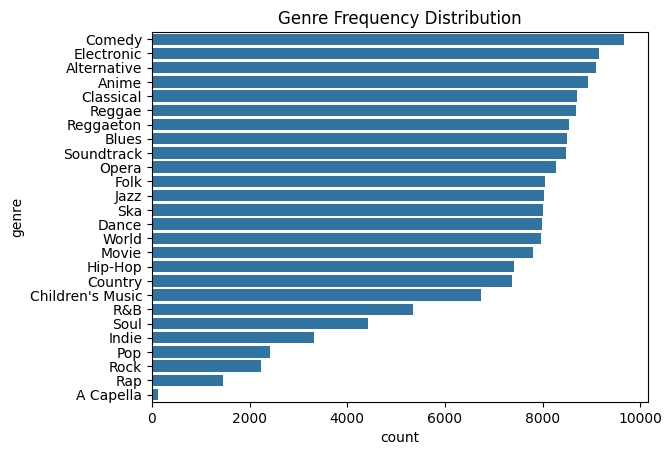

In [57]:
# merge duplicate genres (childrens music x2)
df['genre'] = df['genre'].str.replace("’", "'", regex=False)
df['genre'] = df['genre'].str.replace("‘", "'", regex=False)

sns.countplot(data=df, y='genre', order=df['genre'].value_counts().index)
plt.title("Genre Frequency Distribution")
plt.show()

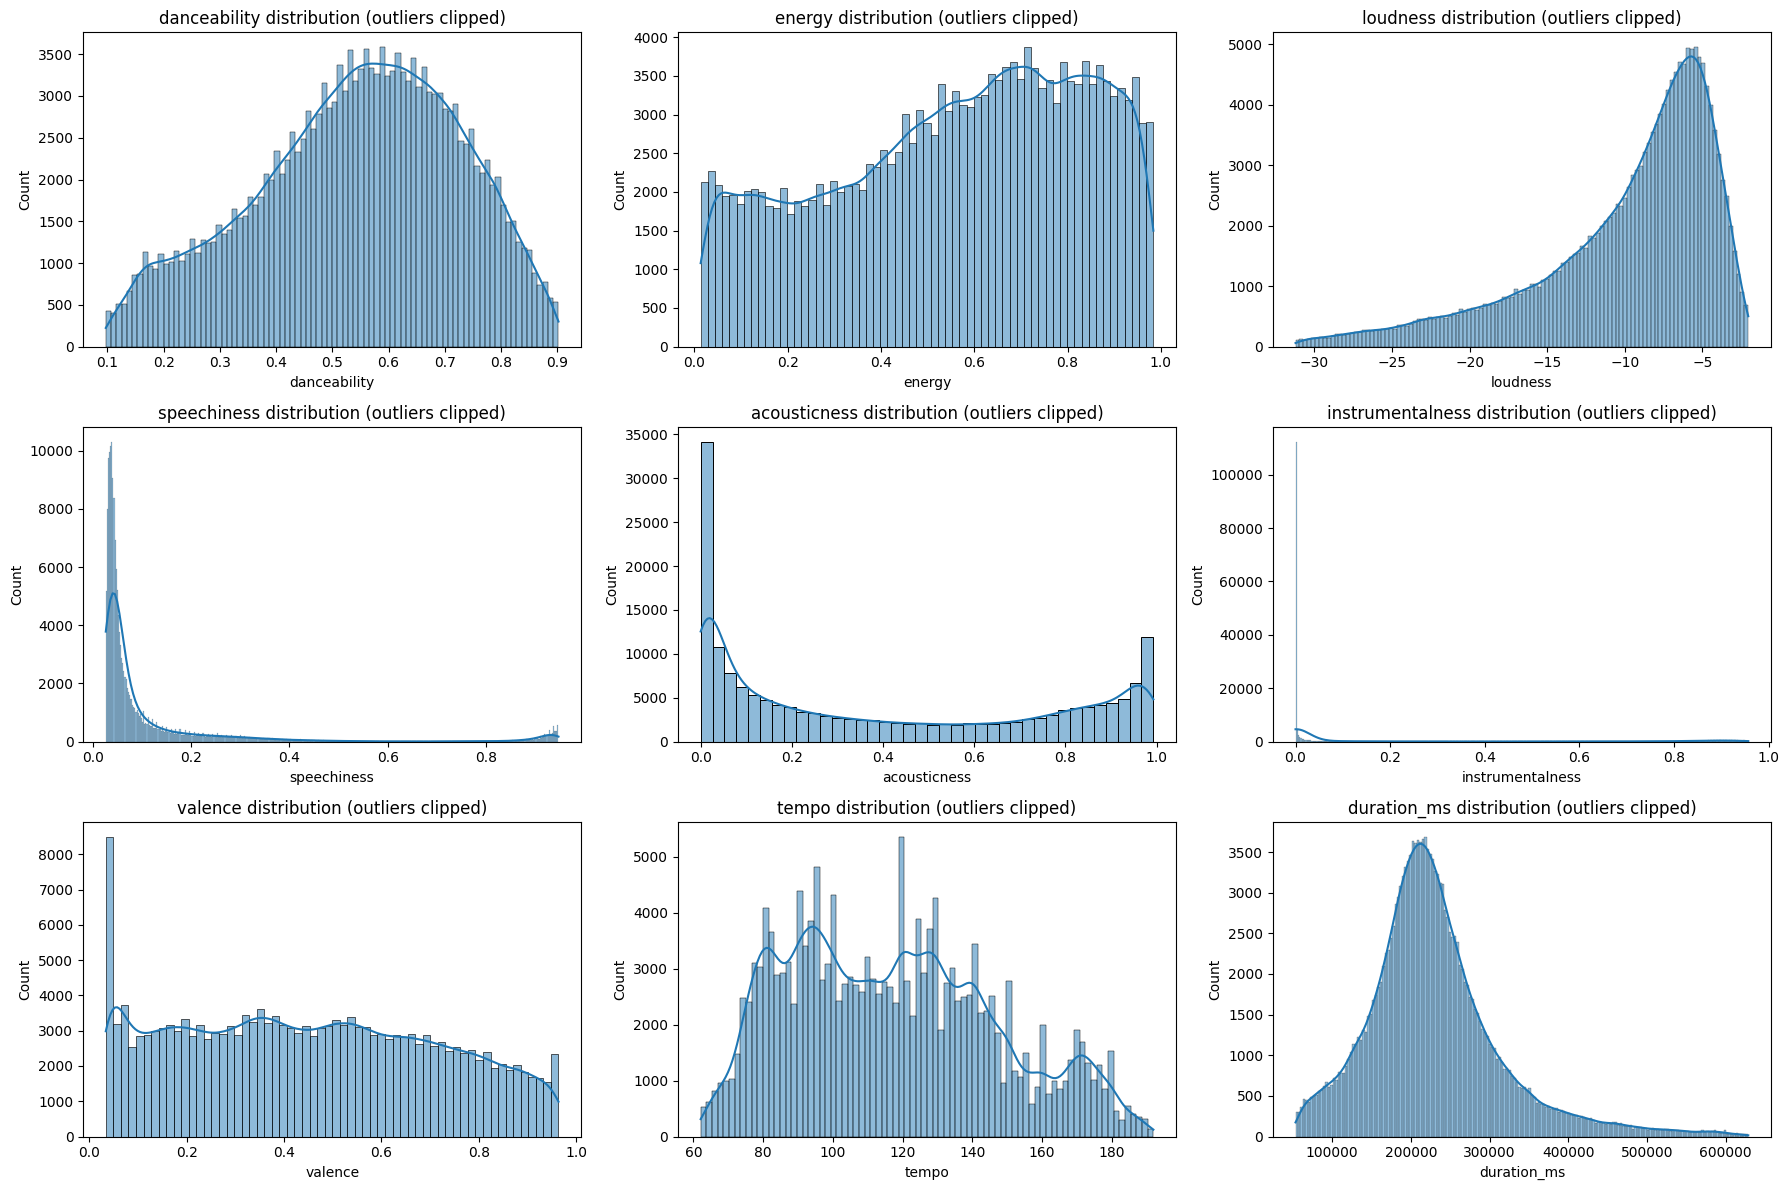

In [29]:
num_cols = ['danceability','energy','loudness','speechiness','acousticness',
            'instrumentalness','valence','tempo','duration_ms']

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, col in enumerate(num_cols):
  # Clip outliers: Keep data within 1st and 99th percentile for better visualization
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    clipped = df[(df[col] >= lower) & (df[col] <= upper)][col]
    sns.histplot(clipped, kde=True, ax=axes[idx])
    axes[idx].set_title(f"{col} distribution (outliers clipped)")

plt.tight_layout()
plt.show()

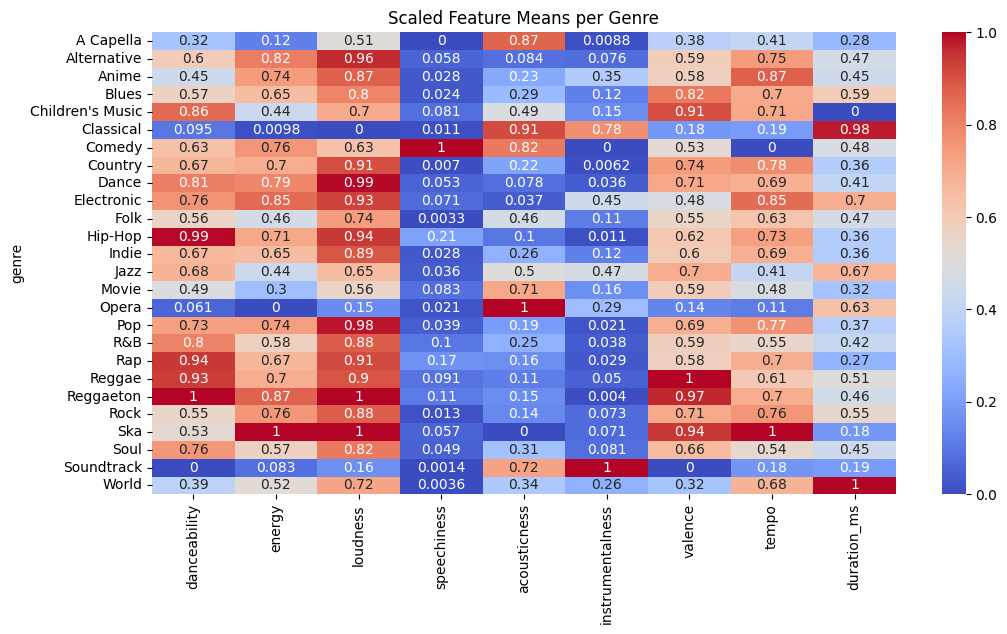

In [30]:
# combine duplicate genres
df['genre'] = df['genre'].str.replace("’", "'", regex=False)
df['genre'] = df['genre'].str.replace("‘", "'", regex=False)

genre_mean = df.groupby("genre")[num_cols].mean()

# Scale each column between 0 and 1 for visualization
viz_scaled = (genre_mean - genre_mean.min()) / (genre_mean.max() - genre_mean.min())

import seaborn as sns
plt.figure(figsize=(12,6))
sns.heatmap(viz_scaled, cmap="coolwarm", annot=True)
plt.title("Scaled Feature Means per Genre")
plt.show()

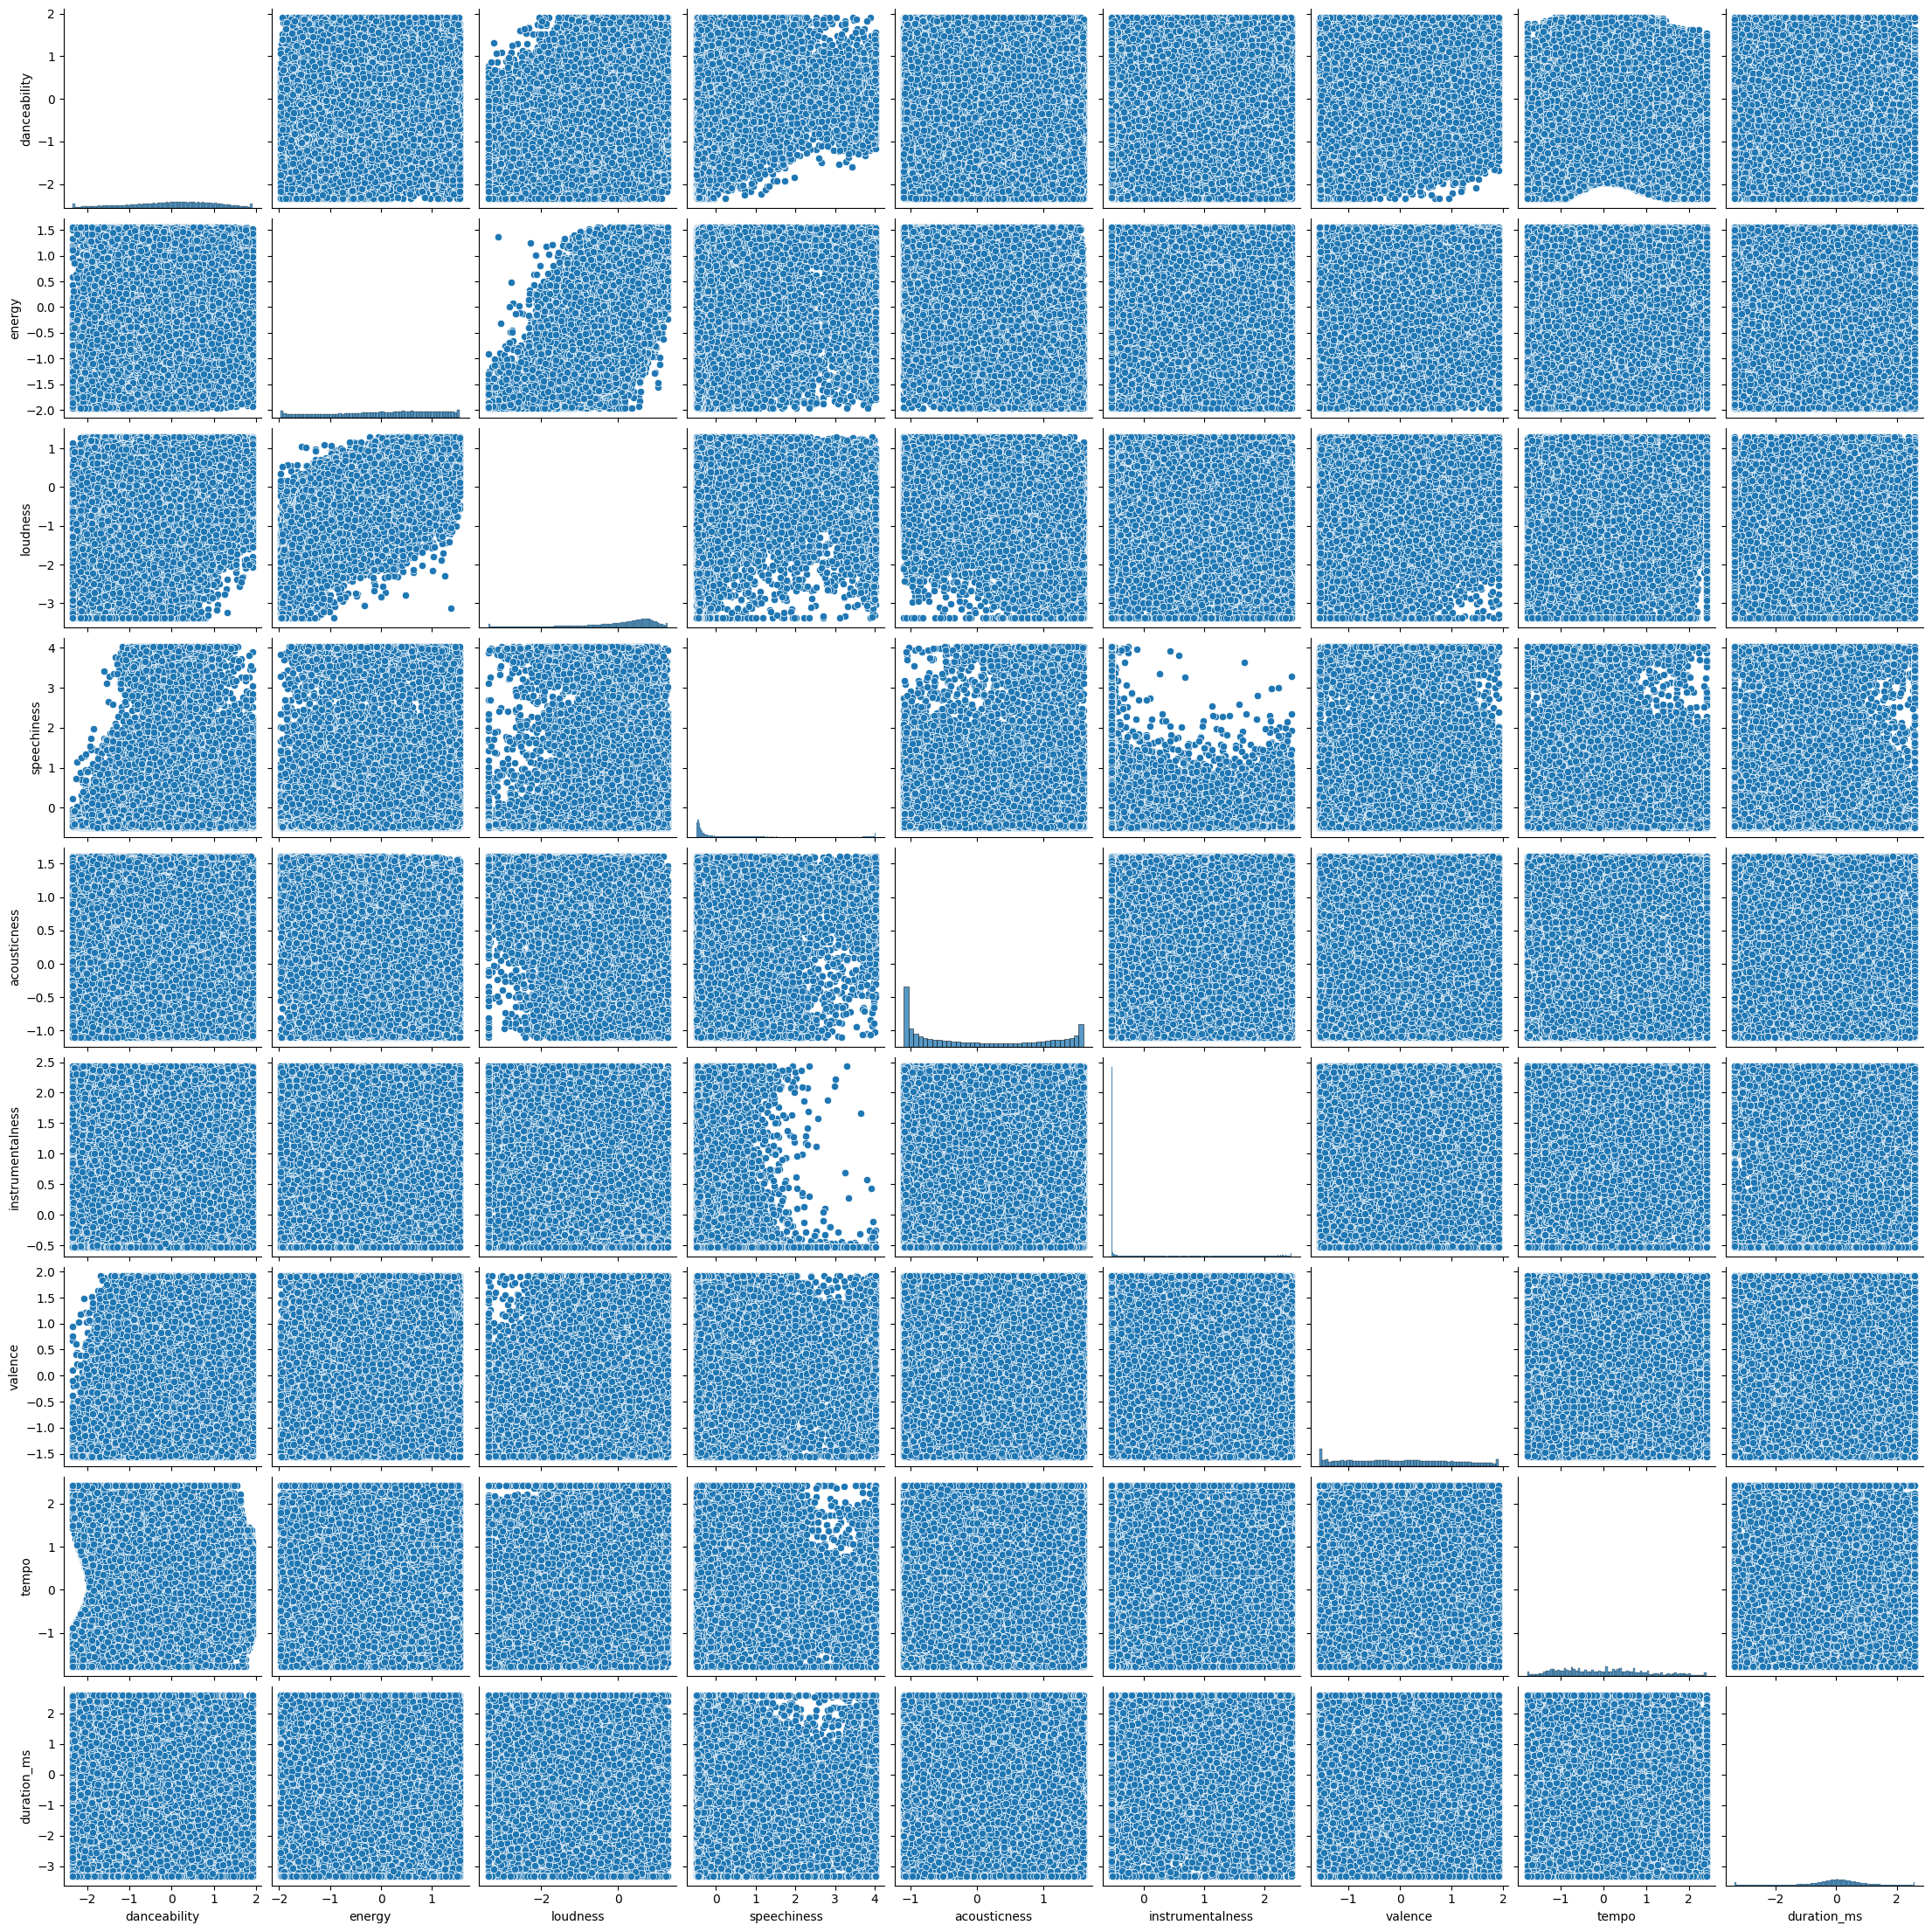

In [54]:
# Pairplot visualization
scaler = StandardScaler()
dfScaled = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols)
sns.pairplot(dfScaled[num_cols])
plt.show()

In [41]:
df[num_cols].skew().sort_values(ascending=False)

duration_ms         9.449356
speechiness         3.102435
instrumentalness    1.578600
tempo               0.406726
acousticness        0.366482
valence             0.148550
energy             -0.330859
danceability       -0.332170
loudness           -1.475319
dtype: float64

## Findings

The dataset initially contained 232,725 songs which was then reduced to 176,774 after removing duplicate songs which made up roughly 24% of the initial data. The data has several numerical features representing audio characteristics of the songs as well as a categorical label of genre. For this analysis we are going to focus on duration, speechiness, instrumentalness, tempo, acousticness, valence, energy, danceability, and loudness as the numerical features. There are a total of 26 genres of music represented with a fairly even spread across the top 20 highest frequency genres. Each feature is important as is displayed by the heatmap, each one contributes to the qualities of a genre in various capacities. From the pairplots we can observe a few correlations between attributes such as loudness x energy, which appears to be the only strong correlation between attributes. There are a few other attributes which appear to have a moderate correlation but in general they don't appear to have significant correlations which is surprising. Lastly, from checking skew we found that duration is significantly skewed and a few metrics like speechiness, instrumentallness and loudness have minor skews.

## Data Cleaning/Preprocessing

In [8]:
# Reimport
df = pd.read_csv("SpotifyFeatures.csv")
df.head()
df = df.drop_duplicates(subset='track_id', keep='first')
num_cols = ['danceability','energy','loudness','speechiness','acousticness',
            'instrumentalness','valence','tempo','duration_ms']

# merge duplicate genres (childrens music x2)
df['genre'] = df['genre'].str.replace("’", "'", regex=False)
df['genre'] = df['genre'].str.replace("‘", "'", regex=False)

# Clip outliers
for col in num_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=lower, upper=upper)

# log transform duration because of heavy skew
df["duration_ms"] = np.log1p(df["duration_ms"])

# scale values since they have vastly varying ranges
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df[num_cols].std()

danceability        1.000003
energy              1.000003
loudness            1.000003
speechiness         1.000003
acousticness        1.000003
instrumentalness    1.000003
valence             1.000003
tempo               1.000003
duration_ms         1.000003
dtype: float64

# 3. Model Architecture

For this task I'm going to compare multiple architectures:

    Model A, MLP
    
    Model B, 1D CNN
    
    Model C, LSTM

Each model makes different assumptions about the structure of the input data so this allows me to evaluate which perspective best fits musical classification. A MLP provides a good baseline and treats the features independently. The 1D CNN will highlight groupings of features and see if those are predictive of genre. Lastly, the LSTM will process features sequentially potentially capturingcontextual dependencies.

I will first focus on the differences between these three models in this section and then later work on hyperparameter tuning.

In [9]:
# Preparing train, val, test data sets
X = df[num_cols].values

# encode genre labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df["genre"].values)
y_onehot = to_categorical(y_encoded)

# split into train, val, test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, stratify=y_onehot)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train.argmax(axis=1))

# reshape for models
X_train_re = X_train.reshape(X_train.shape[0], len(num_cols), 1)
X_val_re   = X_val.reshape(X_val.shape[0], len(num_cols), 1)
X_test_re  = X_test.reshape(X_test.shape[0], len(num_cols), 1)

# define early stopper for all models
early_stop = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)

In [77]:
# plotting function that will be reused for all models
def plot_history(history, title_prefix="Model"):
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title_prefix}: Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title_prefix}: Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title(f'{title_prefix}: AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## MLP Model A

In [75]:
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(len(num_cols),)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

mlp_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name="auc", multi_label=True)]
)

In [76]:
mlp_history = mlp_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=64, callbacks=[early_stop], verbose=1)

Epoch 1/40
1768/1768 [==============================] - 6s 3ms/step - loss: 2.2768 - accuracy: 0.3215 - auc: 0.8064 - val_loss: 2.0549 - val_accuracy: 0.3836 - val_auc: 0.8481
Epoch 2/40
1768/1768 [==============================] - 4s 2ms/step - loss: 2.1315 - accuracy: 0.3626 - auc: 0.8366 - val_loss: 2.0208 - val_accuracy: 0.3914 - val_auc: 0.8545
Epoch 3/40
1768/1768 [==============================] - 4s 2ms/step - loss: 2.0989 - accuracy: 0.3730 - auc: 0.8428 - val_loss: 1.9936 - val_accuracy: 0.3997 - val_auc: 0.8610
Epoch 4/40
1768/1768 [==============================] - 6s 3ms/step - loss: 2.0791 - accuracy: 0.3794 - auc: 0.8445 - val_loss: 1.9779 - val_accuracy: 0.4019 - val_auc: 0.8623
Epoch 5/40
1768/1768 [==============================] - 4s 2ms/step - loss: 2.0670 - accuracy: 0.3832 - auc: 0.8478 - val_loss: 1.9736 - val_accuracy: 0.4042 - val_auc: 0.8650
Epoch 6/40
1768/1768 [==============================] - 4s 2ms/step - loss: 2.0571 - accuracy: 0.3859 - auc: 0.8493 - va

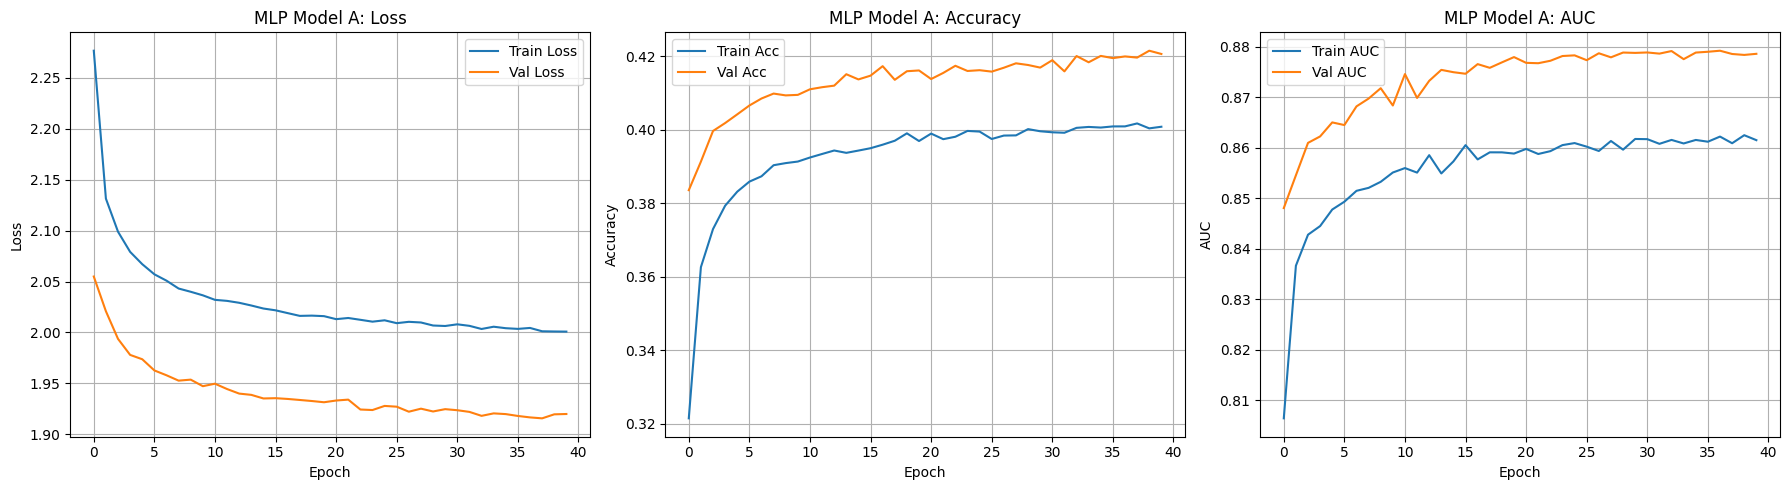

In [78]:
plot_history(mlp_history, title_prefix="MLP Model A")

## 1D CNN Model B

In [81]:
cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(len(num_cols), 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name="auc", multi_label=True)]
)

In [82]:
cnn_history = cnn_model.fit(X_train_re, y_train, validation_data=(X_val_re, y_val), epochs=40, batch_size=64, callbacks=[early_stop], verbose=1)

Epoch 1/40
1768/1768 [==============================] - 6s 3ms/step - loss: 2.3422 - accuracy: 0.2981 - auc: 0.7937 - val_loss: 2.1581 - val_accuracy: 0.3491 - val_auc: 0.8309
Epoch 2/40
1768/1768 [==============================] - 4s 2ms/step - loss: 2.1842 - accuracy: 0.3428 - auc: 0.8266 - val_loss: 2.1155 - val_accuracy: 0.3565 - val_auc: 0.8431
Epoch 3/40
1768/1768 [==============================] - 4s 2ms/step - loss: 2.1555 - accuracy: 0.3518 - auc: 0.8320 - val_loss: 2.0900 - val_accuracy: 0.3656 - val_auc: 0.8473
Epoch 4/40
1768/1768 [==============================] - 5s 3ms/step - loss: 2.1412 - accuracy: 0.3552 - auc: 0.8346 - val_loss: 2.0771 - val_accuracy: 0.3683 - val_auc: 0.8493
Epoch 5/40
1768/1768 [==============================] - 6s 3ms/step - loss: 2.1291 - accuracy: 0.3571 - auc: 0.8363 - val_loss: 2.0718 - val_accuracy: 0.3714 - val_auc: 0.8501
Epoch 6/40
1768/1768 [==============================] - 6s 4ms/step - loss: 2.1210 - accuracy: 0.3606 - auc: 0.8390 - va

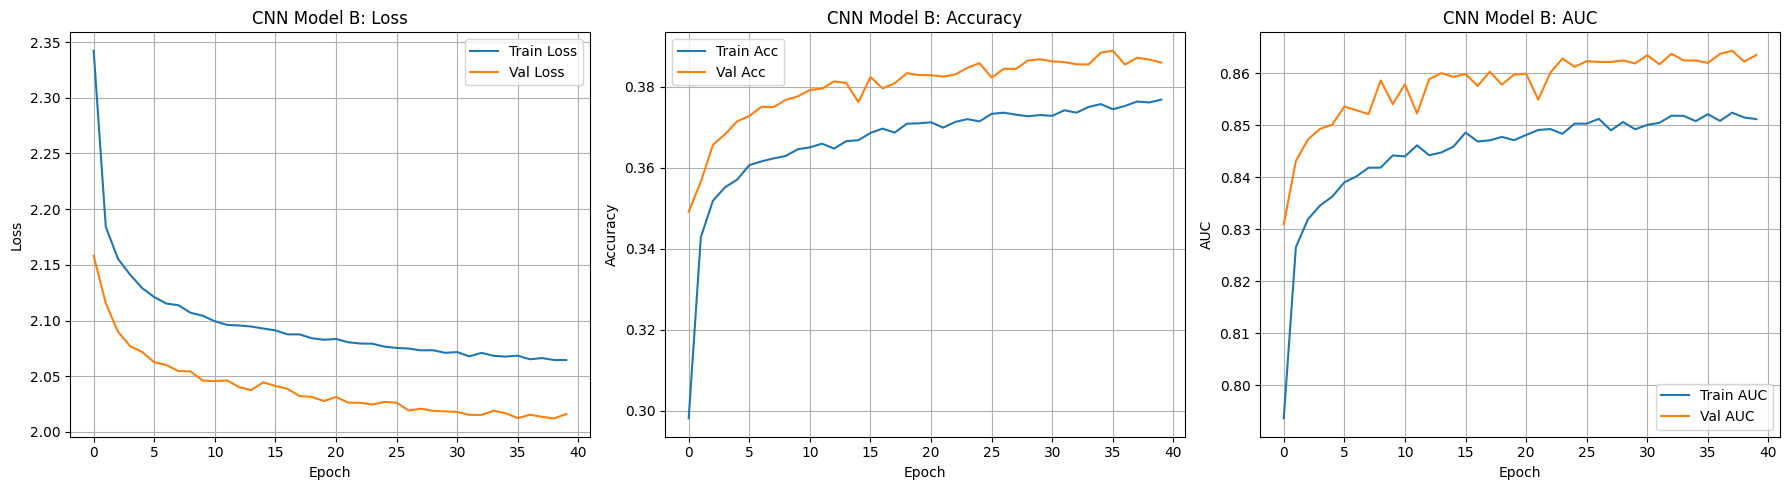

In [83]:
plot_history(cnn_history, title_prefix="CNN Model B")

## LSTM Model C

In [90]:
lstm_model = Sequential([
    LSTM(32, input_shape=(len(num_cols), 1)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name="auc", multi_label=True)]
)

In [91]:
lstm_history = lstm_model.fit(X_train_re, y_train, validation_data=(X_val_re, y_val), epochs=40, batch_size=64, callbacks=[early_stop], verbose=1)

Epoch 1/40
1768/1768 [==============================] - 16s 8ms/step - loss: 2.6006 - accuracy: 0.2074 - auc: 0.7321 - val_loss: 2.3992 - val_accuracy: 0.2816 - val_auc: 0.7828
Epoch 2/40
1768/1768 [==============================] - 10s 6ms/step - loss: 2.3653 - accuracy: 0.2839 - auc: 0.7913 - val_loss: 2.2519 - val_accuracy: 0.3211 - val_auc: 0.8174
Epoch 3/40
1768/1768 [==============================] - 10s 5ms/step - loss: 2.2703 - accuracy: 0.3151 - auc: 0.8106 - val_loss: 2.1845 - val_accuracy: 0.3421 - val_auc: 0.8281
Epoch 4/40
1768/1768 [==============================] - 10s 5ms/step - loss: 2.2164 - accuracy: 0.3348 - auc: 0.8212 - val_loss: 2.1332 - val_accuracy: 0.3545 - val_auc: 0.8363
Epoch 5/40
1768/1768 [==============================] - 9s 5ms/step - loss: 2.1813 - accuracy: 0.3456 - auc: 0.8262 - val_loss: 2.1134 - val_accuracy: 0.3647 - val_auc: 0.8418
Epoch 6/40
1768/1768 [==============================] - 9s 5ms/step - loss: 2.1632 - accuracy: 0.3513 - auc: 0.8315 

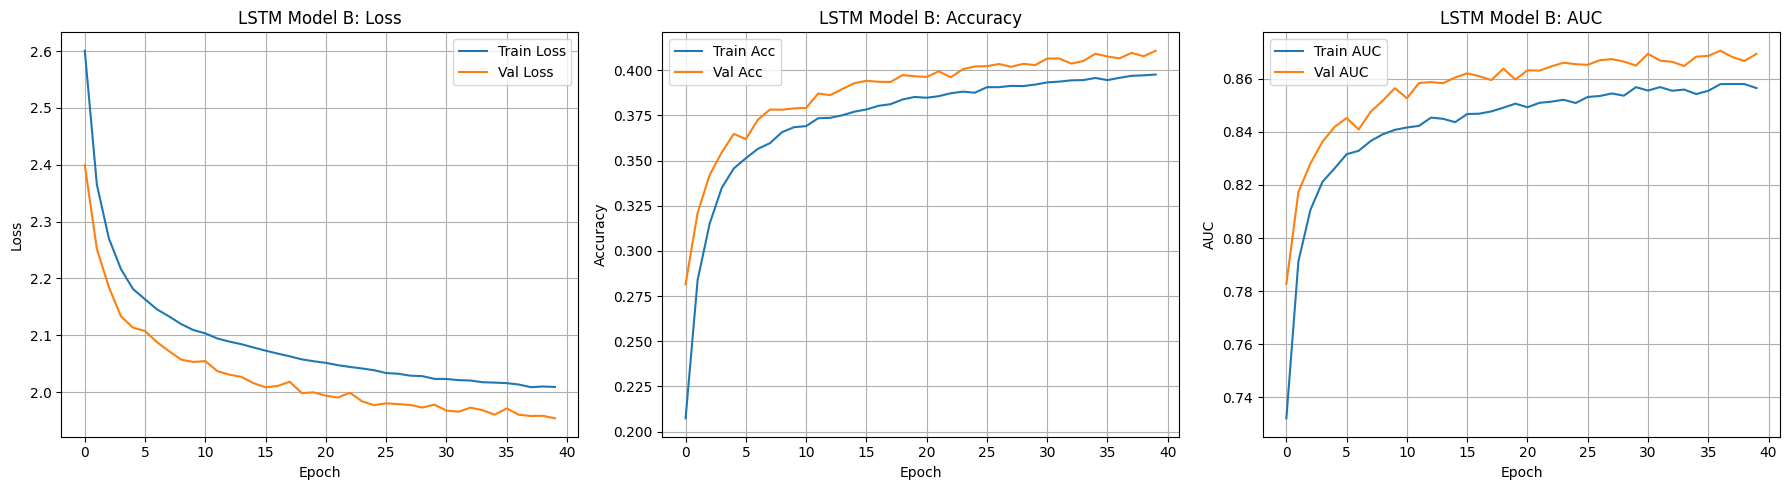

In [92]:
plot_history(lstm_history, title_prefix="LSTM Model B")

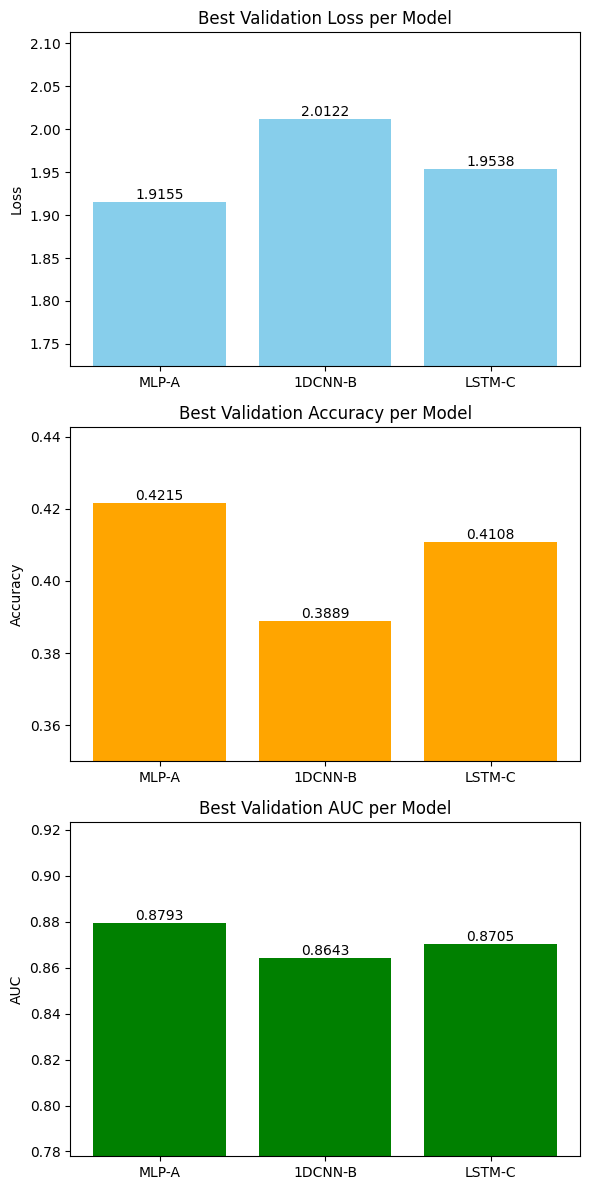

In [95]:
def best_stats(history):
    best_loss = min(history.history['val_loss'])
    best_accuracy = max(history.history['val_accuracy'])
    best_auc = max(history.history['val_auc'])
    return best_loss, best_accuracy, best_auc

losses   = []
accs     = []
aucs     = []

model_names = ["MLP-A", "1DCNN-B", "LSTM-C"]

for hist in [mlp_history,cnn_history,lstm_history]:
    loss, acc, auc = best_stats(hist)
    losses.append(loss)
    accs.append(acc)
    aucs.append(auc)

x = np.arange(len(model_names))

plt.figure(figsize=(6, 12))

plt.subplot(3, 1, 1)
plt.bar(x, losses, color='skyblue')
plt.xticks(x, model_names)
plt.ylabel("Loss")
plt.title("Best Validation Loss per Model")

plt.ylim(min(losses) * 0.90, max(losses) * 1.05)
for i, v in enumerate(losses):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom', fontsize=10)
    
plt.subplot(3, 1, 2)
plt.bar(x, accs, color='orange')
plt.xticks(x, model_names)
plt.ylabel("Accuracy")
plt.title("Best Validation Accuracy per Model")

plt.ylim(min(accs) * 0.90, max(accs) * 1.05)
for i, v in enumerate(accs):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom', fontsize=10)


plt.subplot(3, 1, 3)
plt.bar(x, aucs, color='green')
plt.xticks(x, model_names)
plt.ylabel("AUC")
plt.title("Best Validation AUC per Model")

plt.ylim(min(aucs) * 0.90, max(aucs) * 1.05)
for i, v in enumerate(aucs):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Hyperparameter Tuning on MLP Model

In [10]:
learning_rates = [1e-3, 3e-4, 1e-4]
batch_sizes = [64, 32, 128]

mlp_histories = []
for rate in learning_rates:
    for size in batch_sizes:
        opt = Adam(learning_rate=rate)
        
        mlp_model = Sequential([
            Dense(128, activation='relu', input_shape=(len(num_cols),)),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(y_train.shape[1], activation='softmax')
        ])
        
        mlp_model.compile(
            optimizer=opt,
            loss='categorical_crossentropy',
            metrics=['accuracy', AUC(name="auc", multi_label=True)]
        )
        mlp_histories.append(mlp_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=size, callbacks=[early_stop], verbose=1))

Epoch 1/40
1768/1768 [==============================] - 4s 2ms/step - loss: 2.2793 - accuracy: 0.3211 - auc: 0.8078 - val_loss: 2.0599 - val_accuracy: 0.3857 - val_auc: 0.8449
Epoch 2/40
1768/1768 [==============================] - 3s 2ms/step - loss: 2.1304 - accuracy: 0.3643 - auc: 0.8366 - val_loss: 2.0171 - val_accuracy: 0.3943 - val_auc: 0.8547
Epoch 3/40
1768/1768 [==============================] - 3s 2ms/step - loss: 2.0972 - accuracy: 0.3751 - auc: 0.8403 - val_loss: 1.9989 - val_accuracy: 0.3995 - val_auc: 0.8587
Epoch 4/40
1768/1768 [==============================] - 3s 2ms/step - loss: 2.0767 - accuracy: 0.3802 - auc: 0.8467 - val_loss: 1.9812 - val_accuracy: 0.4000 - val_auc: 0.8606
Epoch 5/40
1768/1768 [==============================] - 3s 2ms/step - loss: 2.0657 - accuracy: 0.3844 - auc: 0.8481 - val_loss: 1.9739 - val_accuracy: 0.4046 - val_auc: 0.8653
Epoch 6/40
1768/1768 [==============================] - 3s 2ms/step - loss: 2.0575 - accuracy: 0.3856 - auc: 0.8514 - va

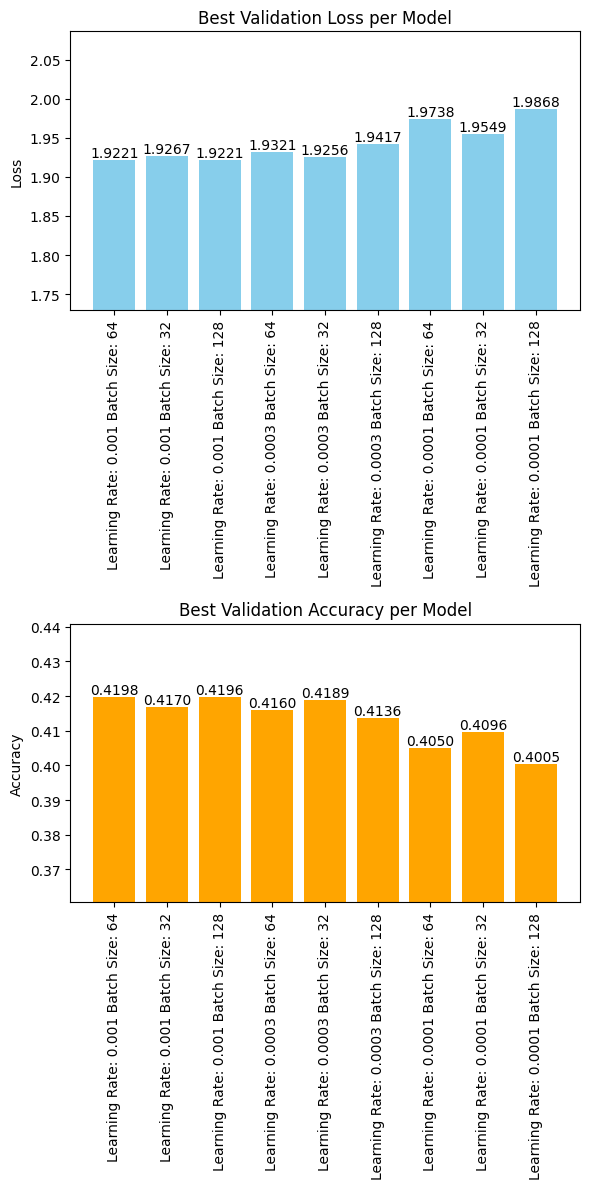

In [12]:
def best_stats(history):
    best_loss = min(history.history['val_loss'])
    best_accuracy = max(history.history['val_accuracy'])
    best_auc = max(history.history['val_auc'])
    return best_loss, best_accuracy, best_auc

losses   = []
accs     = []
aucs     = []

model_names = [f"Learning Rate: {rate} Batch Size: {size}" for rate in learning_rates for size in batch_sizes]

for hist in mlp_histories:
    loss, acc, auc = best_stats(hist)
    losses.append(loss)
    accs.append(acc)
    aucs.append(auc) 

x = np.arange(len(model_names))

plt.figure(figsize=(6, 12))

plt.subplot(2, 1, 1)
plt.bar(x, losses, color='skyblue')
plt.xticks(x, model_names, rotation=90)
plt.ylabel("Loss")
plt.title("Best Validation Loss per Model")

plt.ylim(min(losses) * 0.90, max(losses) * 1.05)
for i, v in enumerate(losses):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom', fontsize=10)
    
plt.subplot(2, 1, 2)
plt.bar(x, accs, color='orange')
plt.xticks(x, model_names, rotation=90)
plt.ylabel("Accuracy")
plt.title("Best Validation Accuracy per Model")

plt.ylim(min(accs) * 0.90, max(accs) * 1.05)
for i, v in enumerate(accs):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.show()

# 4. Results and Analysis

The MLP model performed the best of the three models by a small margin with a roughly 42% accuracy. The LSTM came in second and the 1D CNN in third. This somewhat makes sense based off the previous analysis with the heatmap since the MLP treats features independently and the heatmap indicated that the importance of each feature varied significantly for each genre. While a 42% accuracy may not seem very good, it is around 11 times better than a random selection among the 26 genres present. Since the data samples a relatively uniform amount of each genre it is fair to say that this result is decent and does not simply mirror genre popularity.

Since MLP was my best model I attempted tuning some of the hyperparameters for the model. I tried various combinations of learning rate and batch size, but ultimately the baseline parameters I chose, learning rate = 0.001 and batch size = 64, were the best. Some of the other combinations were fairly close but setting the learning rate too low did noticeably reduce the performance of the models.

## Comparison Against Supervised Learning 

In [94]:
y_train_svm = y_train.argmax(axis=1)
y_val_svm   = y_val.argmax(axis=1)
y_test_svm  = y_test.argmax(axis=1)

svm = SVC(kernel='rbf', C=2, gamma='scale')

svm.fit(X_train, y_train_svm)

svm_preds = svm.predict(X_test)

svm_acc = accuracy_score(y_test_svm, svm_preds)

print("SVM Test Accuracy:", svm_acc)

SVM Test Accuracy: 0.420845707820676


# 5. Conclusion

In conclusion, the MLP model performed the best of my three models by a moderate amount with an accuracy of 42%. This was a relatively decent performance considering a true random selection from 26 genres would result in an accuracy of only 3.84%.

Hyperparameter tuning batch size and learning rates did not end up improving my MLP model's performance. 

For comparison I ran an SVM model which is generally one of the best models for low-dimensional feature spaces like this and it's performance was roughly the same as my MLP model. 

In the future, I think building a model which outputs a set of two or three predictions would be much more fitting for this type of classification since music can often fall into multiple genres. I think a model like that would have extremely high accuracy compared to my current models. Another thing I would do is try training my models again without removing duplicate songs from my data since it's likely they were duplicated because they similarly fell into multiple genres.